# Titanic - Machine Learning from Disaster

#### **Project Goal**  
The objective of this project is to develop a machine learning model that predicts which passengers survived the Titanic shipwreck.

---

### **Overview**  
The dataset is divided into two subsets:  

- **Training Set (`train.csv`)**:  
  This dataset is used to train machine learning models. It includes both passenger features and their survival status (ground truth). The model will learn patterns from the features, such as passenger gender, class, and other attributes. Additional feature engineering can be applied to create new informative features.

- **Test Set (`test.csv`)**:  
  This dataset is used to evaluate the model’s performance on unseen data. It contains the same features as the training set but does **not** include the survival outcome. The task is to predict whether each passenger in the test set survived the Titanic disaster using the trained model.

Additionally, the dataset includes **`gender_submission.csv`**, which provides a sample submission assuming that all female passengers survived. This serves as a reference format for submission files.

---

### **Data Dictionary**  
The dataset contains the following variables:

| **Variable**  | **Definition**                                | **Key**                      |
|--------------|---------------------------------------------|-----------------------------|
| `survival`   | Survival outcome                           | 0 = No, 1 = Yes             |
| `pclass`     | Ticket class (proxy for socio-economic status) | 1 = 1st, 2 = 2nd, 3 = 3rd  |
| `sex`        | Passenger gender                           | Male/Female                 |
| `age`        | Age of the passenger                      | Numeric                     |
| `sibsp`      | Number of siblings/spouses aboard         | Numeric                     |
| `parch`      | Number of parents/children aboard        | Numeric                     |
| `ticket`     | Ticket number                            | Alphanumeric                 |
| `fare`       | Passenger fare                           | Numeric                      |
| `cabin`      | Cabin number                             | Alphanumeric (some missing)  |
| `embarked`   | Port of embarkation                      | C = Cherbourg, Q = Queenstown, S = Southampton |

---

### **Variable Notes**  
- **`pclass`**: Represents socio-economic status (SES):  
  - 1st = Upper class  
  - 2nd = Middle class  
  - 3rd = Lower class  

- **`age`**:  
  - If the age is **less than 1 year**, it is represented as a fraction.  
  - If the age is estimated, it is noted as `xx.5`.  

- **`sibsp`**: Number of family members aboard, defined as:  
  - **Sibling**: Brother, sister, stepbrother, stepsister.  
  - **Spouse**: Husband, wife (mistresses and fiancés were not included).  

- **`parch`**: Number of family members aboard, defined as:  
  - **Parent**: Mother, father.  
  - **Child**: Son, daughter, stepson, stepdaughter.  
  - **Note**: Some children traveled only with a nanny, so their `parch` value is `0`.  

---

## **Project Execution Plan**  

#**1. Data Loading & Initial Inspection**
   - Load the dataset (`train.csv`, `test.csv`) and verify successful loading.
   - Explore the dataset structure, check feature types, and inspect a few samples.
   - Identify missing values, inconsistencies, or formatting issues.

#**2. Data Preprocessing**
   - Investigate missing values and decide on appropriate handling strategies (e.g., imputation, removal).
   - Identify and remove duplicate records if they exist.
   - Convert data types where necessary (e.g., categorical encoding).
   - Standardize and clean textual or categorical variables (e.g., embarked port codes).

#**3. Exploratory Data Analysis (EDA)**
   - Visualize distributions of numerical and categorical variables.
   - Identify anomalies and outliers in numerical features.
   - Explore relationships between features and survival rate.
   - Perform feature selection to identify the most important predictors.

#**4. Data Preparation & Feature Engineering**
   - Create a data preprocessing pipeline to automate transformations:
     - Handle missing values.
     - Encode categorical variables (e.g., one-hot encoding for `embarked`).
     - Scale numerical features for models that require it.
   - Generate new features based on insights from EDA:
     - **Family size** (`sibsp + parch + 1`).
     - **Title extraction** from names.
     - **Cabin information** grouping (if usable).
     - **Age grouping** to capture age-related survival trends.

#**5. Model Training & Hyperparameter Tuning**
   - Split the dataset into training and validation subsets.
   - Train multiple machine learning models (Logistic Regression, Decision Trees, Random Forest, Gradient Boosting).
   - Tune hyperparameters using cross-validation.
   - Compare models based on performance metrics such as accuracy, precision, recall, and F1-score.
   - Handle class imbalance if necessary (e.g., through resampling techniques).

#**6. Model Evaluation & Selection**
   - Compare different models’ performance on validation data.
   - Choose the best-performing model based on accuracy and interpretability.
   - Analyze feature importance to understand which attributes contributed most to survival predictions.
   - Test the model on the unseen `test.csv` dataset.

#**7. Conclusion & Documentation**
   - Summarize findings from data exploration and feature engineering.
   - Provide insights into why certain features were important.
   - Justify model selection and compare it with baseline models (e.g., gender-based assumptions).
   - Suggest potential improvements for future iterations.
   - Format final submission file and validate results.

---

# Data loading

In [489]:
# Standard libraries
import time
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Additional libraries
import phik
import shap

# Sklearn imports
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_auc_score, make_scorer, recall_score, confusion_matrix, precision_score
from sklearn.impute import SimpleImputer

# XGBoost import
from xgboost import XGBClassifier

# Constants
RANDOM_STATE = 42

In [490]:
# Load datasets
test = pd.read_csv("/home/nickolas/data_science/titanic/source/test.csv")
train = pd.read_csv("/home/nickolas/data_science/titanic/source/train.csv")
gender_sub = pd.read_csv("/home/nickolas/data_science/titanic/source/gender_submission.csv")

# Check 5 first rows of each datasets
print("test.csv:")
display(test.head())
test.info()

print("train.csv:")
display(train.head())
train.info()

print("gender_sub.csv:")
display(gender_sub.head())
gender_sub.info()

test.csv:


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB
train.csv:


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
gender_sub.csv:


,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   PassengerId  418 non-null    int64
 1   Survived     418 non-null    int64
dtypes: int64(2)
memory usage: 6.7 KB


**Data Overview**
**1. train.csv (Training Set)**
- **891 entries**, **12 columns** (including `Survived` as the target variable).
- **Issues Identified:**
  - `Age` → **177 missing values**.
  - `Cabin` → **687 missing values** (**very high!**).
  - `Embarked` → **2 missing values**.

**2. test.csv (Test Set)**
- **418 entries**, **11 columns** (no `Survived` column).
- **Issues Identified:**
  - `Age` → **86 missing values**.
  - `Fare` → **1 missing value**.
  - `Cabin` → **327 missing values**.

**3. gender_submission.csv (Submission Example)**
- **Contains only 2 columns:** `PassengerId` and `Survived`.
- This is a template assuming **all females survive** while **all males do not**.

---

Rename columns: lowercase and replace spaces with underscores

In [491]:
# Function to rename columns: lowercase and replace spaces with underscores
def clean_column_names(df):
    df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")
    return df

# Apply column name transformation
train = clean_column_names(train)
test = clean_column_names(test)

Fill missing values in age, fare and embarked with the median of pclass and create a binary feature cabin_known.

In [492]:
for dataset in [train, test]:
    dataset["age"] = dataset.groupby("pclass")["age"].transform(lambda x: x.fillna(x.median()))
    dataset["fare"] = dataset.groupby("pclass")["fare"].transform(lambda x: x.fillna(x.median()))
    
    # Fill embarked with the most frequent value (mode)
    dataset["embarked"] = dataset["embarked"].fillna(dataset["embarked"].mode()[0])

    # Create a binary feature cabin_known (1 if Cabin info exists, 0 otherwise)
    dataset["cabin_known"] = dataset["cabin"].notna().astype(int)

    # Remove the original cabin column
    dataset.drop(columns=["cabin"], inplace=True)

print("Processing complete.")

Processing complete.


In [493]:
# Check missing values
train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   passengerid  891 non-null    int64  
 1   survived     891 non-null    int64  
 2   pclass       891 non-null    int64  
 3   name         891 non-null    object 
 4   sex          891 non-null    object 
 5   age          891 non-null    float64
 6   sibsp        891 non-null    int64  
 7   parch        891 non-null    int64  
 8   ticket       891 non-null    object 
 9   fare         891 non-null    float64
 10  embarked     891 non-null    object 
 11  cabin_known  891 non-null    int64  
dtypes: float64(2), int64(6), object(4)
memory usage: 83.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   passengerid  418 non-null    int64  
 1   pclass  

Check duplicates

In [494]:
print(f'\ntrain duplicates: {train.duplicated().sum()}')
print(f'\ntest duplicates: {test.duplicated().sum()}')


train duplicates: 0

test duplicates: 0


# Exploratory Data Analysis (EDA)

## Statistical analysis of quantitative features

In [495]:
print("train statistical analysis:")
display(train.drop(columns='passengerid', errors='ignore').describe())

print("test statistical analysis:")
display(train.drop(columns='passengerid', errors='ignore').describe())

train statistical analysis:


,survived,pclass,age,sibsp,parch,fare,cabin_known
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.066409,0.523008,0.381594,32.204208,0.228956
std,0.486592,0.836071,13.244532,1.102743,0.806057,49.693429,0.420397
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400,0.000000
50%,0.000000,3.000000,26.000000,0.000000,0.000000,14.454200,0.000000
75%,1.000000,3.000000,37.000000,1.000000,0.000000,31.000000,0.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,1.000000


test statistical analysis:


,survived,pclass,age,sibsp,parch,fare,cabin_known
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.066409,0.523008,0.381594,32.204208,0.228956
std,0.486592,0.836071,13.244532,1.102743,0.806057,49.693429,0.420397
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400,0.000000
50%,0.000000,3.000000,26.000000,0.000000,0.000000,14.454200,0.000000
75%,1.000000,3.000000,37.000000,1.000000,0.000000,31.000000,0.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,1.000000


### **Key Insights from Statistical Analysis of the Titanic Dataset**

#### **1. Survival Rate (`survived`)**
- **Mean: 0.38 (≈ 38.4%)** → Around **38% of passengers survived**, meaning **62% perished**.
- The dataset is **imbalanced**, with more non-survivors than survivors.
- The `survived` column only exists in the training dataset (not in test).

#### **2. Passenger Class Distribution (`pclass`)**
- **Mean: 2.31**, which suggests that most passengers belonged to **lower classes (2nd and 3rd)**.
- **25% percentile is in 2nd class, and the median (50%) is in 3rd class** → Majority of passengers traveled in **3rd class**.
- Since ticket class could be linked to socio-economic status, it might be **a strong predictor of survival**.

#### **3. Age Distribution (`age`)**
- **Mean: 29 years**, with a **standard deviation of 13.2 years**.
- **Range: 0.42 - 80 years** → The youngest passenger was **an infant**, and the oldest was **80 years old**.
- **50% of passengers were younger than 26 years old**.
- **Possible Impact**: Children and elderly might have different survival rates.

#### **4. Family Connections (`sibsp` and `parch`)**
- **Most passengers traveled alone**:  
  - **50% had no siblings or spouses (`sibsp = 0`)**.
  - **50% had no parents or children (`parch = 0`)**.
- **Max values**: Some passengers had up to **8 siblings/spouses** or **6 parents/children**.
- **Possible Impact**: Family connections might have influenced survival (e.g., women/children helped first).

#### **5. Fare Distribution (`fare`)**
- **Mean: 32.20** with a **high standard deviation (49.69)**.
- **25% percentile: 7.91, 50%: 14.45, 75%: 31.00** → Most fares were **relatively low**.
- **Max fare: 512.33** → Some first-class passengers paid significantly more.
- **Possible Impact**: Higher ticket prices might indicate **wealth and higher survival chances**.

#### **6. Cabin Information (`cabin_known`)**
- **Only ~22.9% of passengers had cabin information** (`cabin_known = 1`).
- Most passengers (77.1%) had missing cabin data (`cabin_known = 0`), likely 3rd-class passengers.
- **Possible Impact**: Knowing the cabin number may correlate with **first-class passengers**, who might have had **better survival odds**.

---

## Grapfics and summaries

### Quantitative features

Train plots:


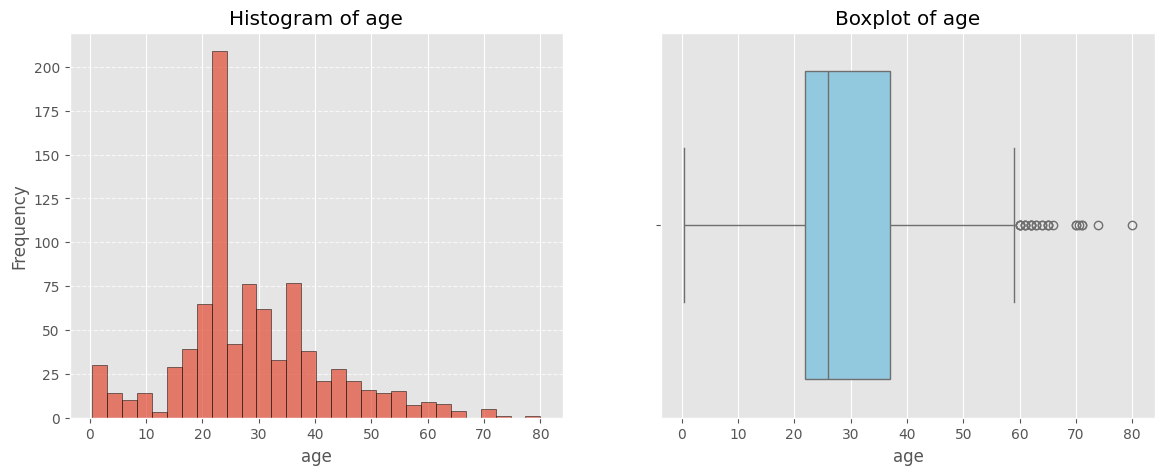

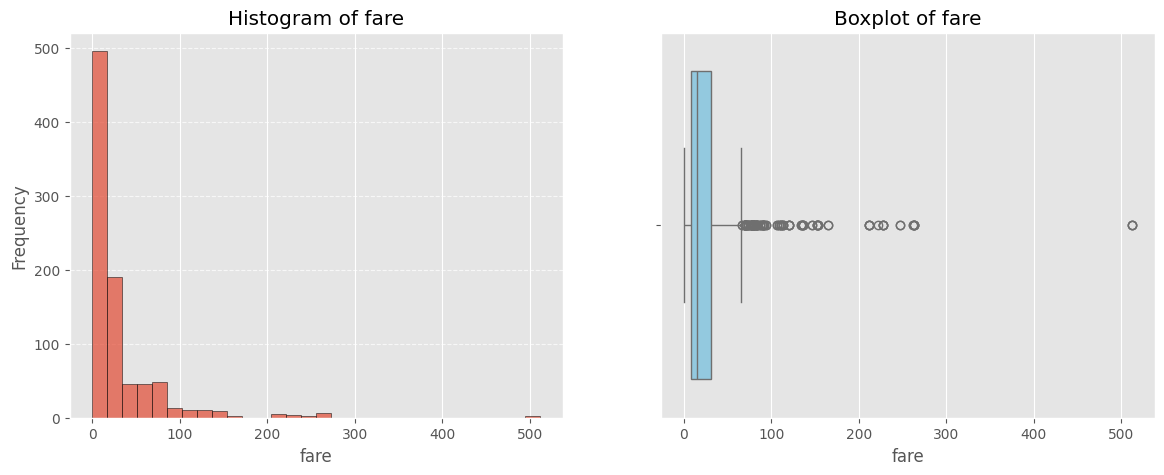

Test plots:


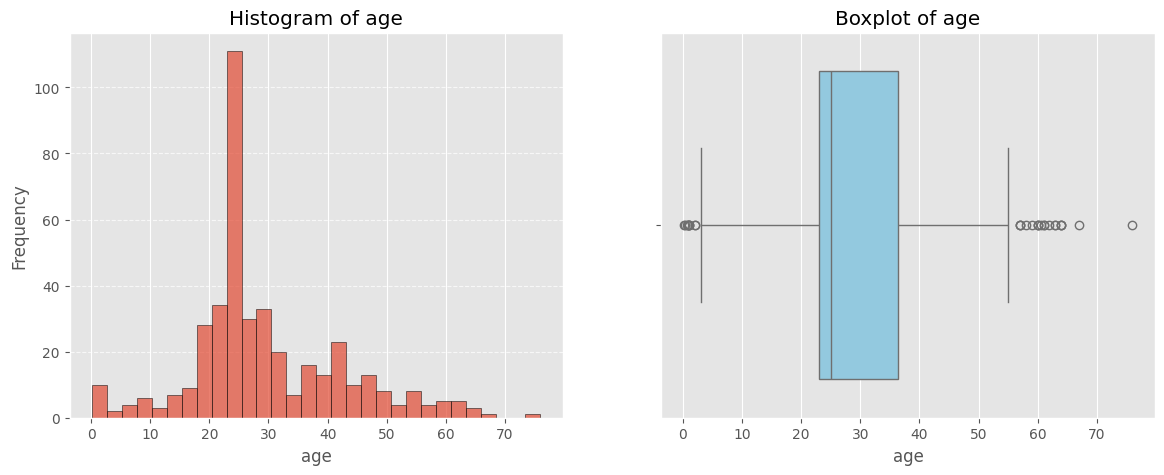

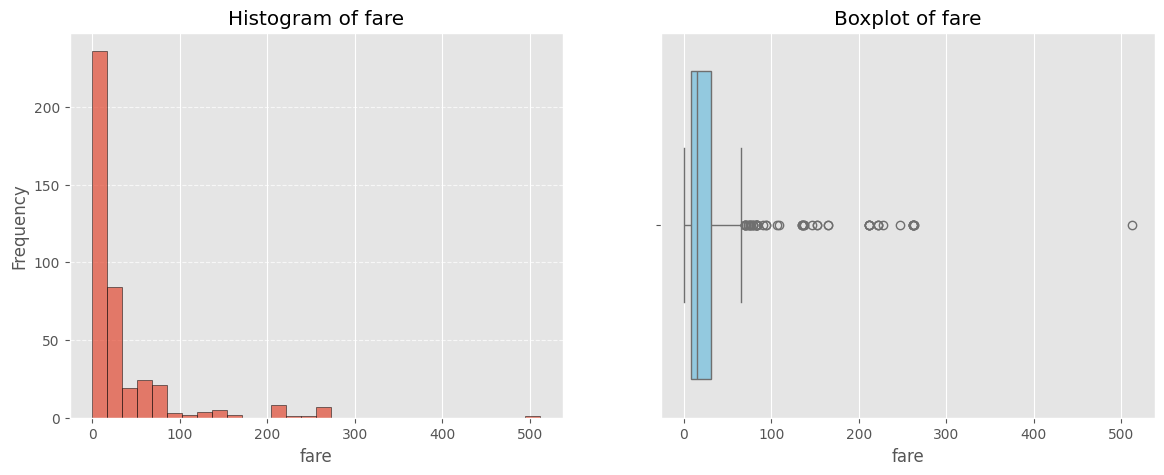

In [496]:
# Numerical columns to plot
numerical_columns = ["age", "fare"]

# Set the plot style
plt.style.use("ggplot")

def plot_numerical_features(data, dataset_name):
    """Plots histograms and boxplots for numerical features."""
    print(f"{dataset_name} plots:")
    for col in numerical_columns:
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))

        # Histogram
        axes[0].hist(data[col], bins=30, edgecolor="black", alpha=0.7)
        axes[0].set_title(f"Histogram of {col}")
        axes[0].set_xlabel(col)
        axes[0].set_ylabel("Frequency")
        axes[0].grid(axis="y", linestyle="--", alpha=0.7)

        # Boxplot
        sns.boxplot(x=data[col], ax=axes[1], color="skyblue")
        axes[1].set_title(f"Boxplot of {col}")

        plt.show()

# Generate plots for both datasets
plot_numerical_features(train, "Train")
plot_numerical_features(test, "Test")

Train plots:


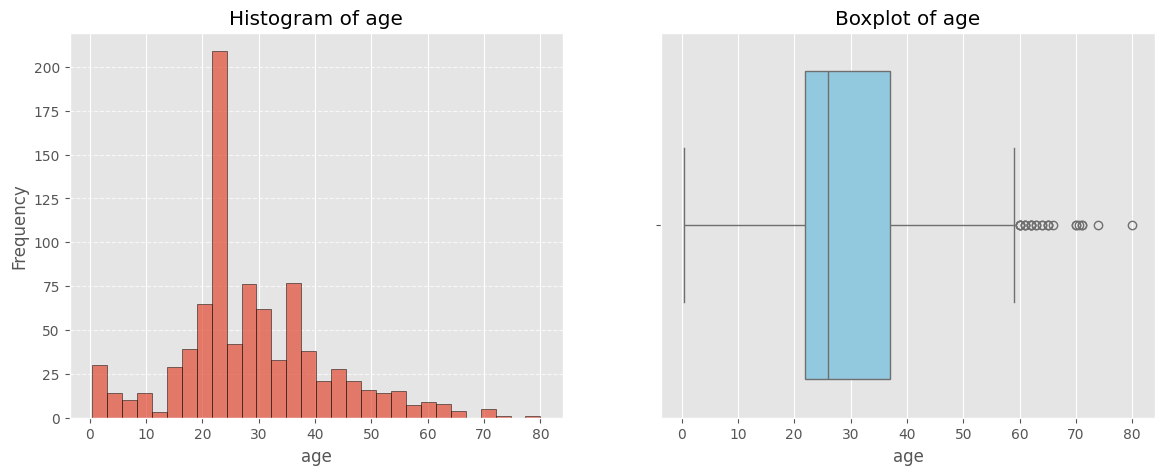

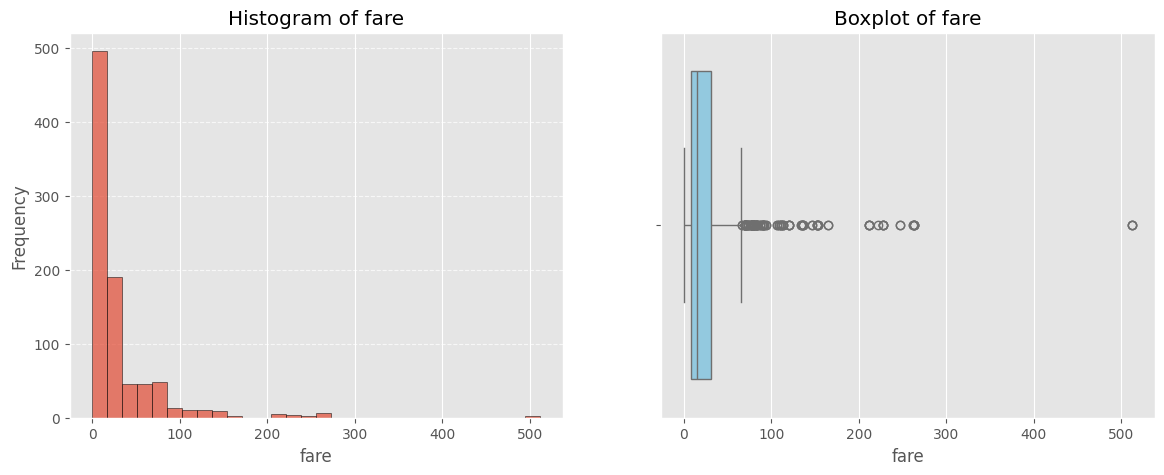

Test plots:


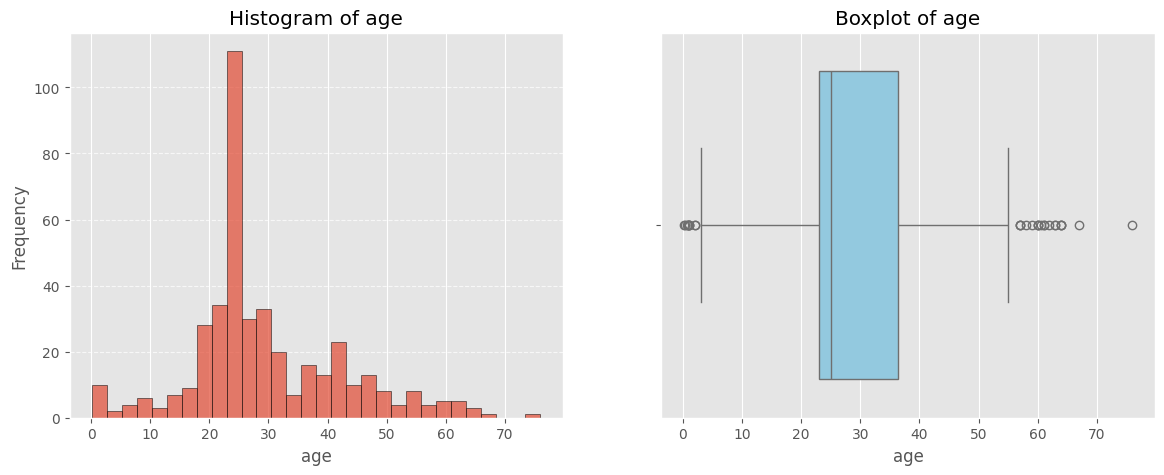

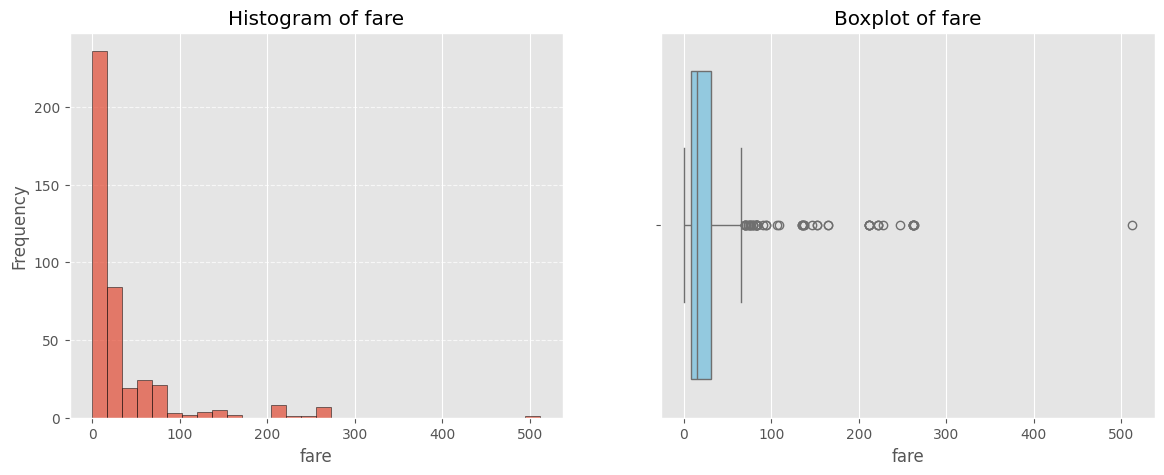

In [497]:
# Numerical columns to plot
numerical_columns = ["age", "fare"]

# Set the plot style
plt.style.use("ggplot")

def plot_numerical_features(data, dataset_name):
    """Plots histograms and boxplots for numerical features."""
    print(f"{dataset_name} plots:")
    for col in numerical_columns:
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))

        # Histogram
        axes[0].hist(data[col], bins=30, edgecolor="black", alpha=0.7)
        axes[0].set_title(f"Histogram of {col}")
        axes[0].set_xlabel(col)
        axes[0].set_ylabel("Frequency")
        axes[0].grid(axis="y", linestyle="--", alpha=0.7)

        # Boxplot
        sns.boxplot(x=data[col], ax=axes[1], color="skyblue")
        axes[1].set_title(f"Boxplot of {col}")

        plt.show()

# Generate plots for both datasets
plot_numerical_features(train, "Train")
plot_numerical_features(test, "Test")


### **Quantitative features overall Summary**

**1. Survival Rate & Class Distribution**
- **Only 38% of passengers survived**, making the dataset **imbalanced** with more non-survivors than survivors.
- **Most passengers traveled in 3rd class**, indicating that lower socio-economic status was more common.
- **Ticket class (`pclass`) is likely a strong predictor of survival**, as wealthier passengers (1st class) may have had better access to lifeboats.

**2. Age & Family Influence on Survival**
- The **average age of passengers was 29 years**, but there is **a wide spread from 0.42 to 80 years**.
- **50% of passengers were younger than 26 years old**, suggesting a younger population.
- **Most passengers traveled alone**, with 50% having **no siblings, spouses, parents, or children aboard**.
- **Passengers with family connections (sibsp, parch) may have had higher survival chances**, especially women and children.

**3. Ticket Fare & Socio-Economic Impact**
- **Average fare was $32.20**, but there is **a very high variance**.
- **Most fares were relatively low**, with 75% of passengers paying **less than $31**.
- **Some passengers paid over $500**, indicating a huge disparity in socio-economic status.
- **Higher ticket prices may correlate with higher survival rates**, as wealthier passengers likely had better conditions and access to lifeboats.

**4. Cabin Information & Missing Data**
- **Only 22.9% of passengers had recorded cabin data**, meaning most passengers (likely 3rd class) had no assigned cabins.
- **Cabin information could be a strong indicator of survival**, as it likely correlates with class.

---

**Statistical Tests for Normality**
**1. Age Distribution**
- **Shapiro-Wilk, D’Agostino-Pearson, and Kolmogorov-Smirnov tests all reject normality** (p-value < 0.05).
- **The age distribution is not normal**.
- **Outliers detected** for passengers **58 years and older**.

**2. Fare Distribution**
- **Highly skewed distribution** (many passengers paid very low fares, while a few paid extreme amounts).
- **All normality tests reject normality** (p-value < 0.05).
- **Significant number of outliers above $80**, meaning **high-ticket passengers were rare**.

---

### Feature Engineering

We introduce two key engineered features: **`family_size`** and **`socio_economic_status`**, both of which aim to enhance the predictive power of our survival model.

---

**1. Family Size (`family_size`)**

- The number of family members aboard the Titanic likely influenced survival chances.
- Families were more likely to **help each other**, which could increase survival odds.
- Conversely, **large families** might have struggled to stay together, leading to lower survival rates.

**Implementation:**
We define family size as:

**family_size = sibsp + parch + 1**

Where:
- **`sibsp`** (Siblings/Spouses Aboard)
- **`parch`** (Parents/Children Aboard)
- **`+1`** accounts for the passenger themselves.

**Expected Impact:**
- **Small families (1-3 members)**: Likely higher survival rates due to **prioritization and assistance**.
- **Large families (5+ members)**: May have **lower survival rates**, as staying together in an emergency was more difficult.

---

**2. Socio-Economic Status (`socio_economic_status`)**

- **Class, fare, and cabin information** provide strong signals of socio-economic status.
- First-class passengers had better **access to lifeboats**, while third-class passengers were at a **disadvantage**.
- A passenger’s **ticket fare and whether they had an assigned cabin** could indicate wealth and access to resources.

**Implementation:**
We categorize passengers into three **socio-economic groups** using:
1. **Low Status (0)**: 3rd class, lowest fare, and no assigned cabin.
2. **Medium Status (1)**: 2nd class with a medium fare.
3. **High Status (2)**: 1st class, highest fare, or passengers with a known cabin.

**Expected Impact:**
- **High socio-economic status (1st class, high fare, known cabin)** → **Higher survival rates**.
- **Low socio-economic status (3rd class, low fare, no cabin)** → **Lower survival rates**.

---

In [498]:
train['family_size'] = train['sibsp'] + train['parch'] + 1
test['family_size'] = test['sibsp'] + test['parch'] + 1

In [499]:
def add_socio_economic_status(df):
    """
    This function adds the 'socio_economic_status' feature to the dataframe `df`.
    It uses `pclass`, `fare`, and `cabin_known` to create a new combined feature.
    
    Args:
    df (pd.DataFrame): The input dataframe, either `train` or `test`.
    
    Returns:
    pd.DataFrame: The dataframe with the new 'socio_economic_status' feature.
    """
    
    # Create fare categories (Low, Medium, High) based on quantiles
    df['fare_category'] = pd.qcut(df['fare'], 3, labels=[0, 1, 2])  # Fare: low, medium, high

    # Create a new combined feature for socio-economic status
    df['socio_economic_status'] = np.where(
        # Low status: 3rd class, low fare, and no cabin information
        (df['pclass'] == 3) & (df['fare_category'] == 0) & (df['cabin_known'] == 0), 0,  
        np.where(
            # Medium status: 2nd class and medium fare
            (df['pclass'] == 2) & (df['fare_category'] == 1), 1,  
            np.where(
                # High status: 1st class, high fare, or known cabin
                (df['pclass'] == 1) | (df['fare_category'] == 2) | (df['cabin_known'] == 1), 2,  
                # For everything else, consider high status
                2  
            )
        )
    )

    # Convert to categorical type
    df['socio_economic_status'] = df['socio_economic_status'].astype('category')
    
    return df


# Example usage with train and test datasets
train = add_socio_economic_status(train)
test = add_socio_economic_status(test)


### Categorical features

In [500]:
# Remove the "ticket" column (as it is not a significant feature)
train.drop(columns=["ticket"], inplace=True)
test.drop(columns=["ticket"], inplace=True)

In [501]:
# Define categorical features
categorical_features = ['pclass', 'sex', 'sibsp', 'parch', 'cabin_known', 'family_size', 'socio_economic_status']
# Features that should be plotted vertically (bar chart with values on Y-axis)
vertical_features = ['sex', 'embarked']

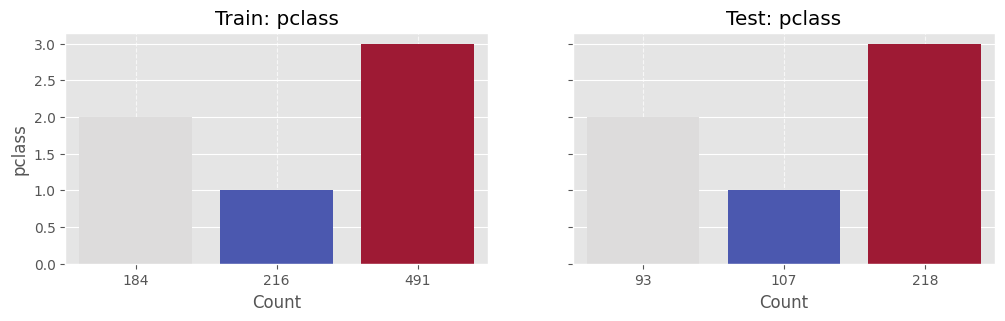

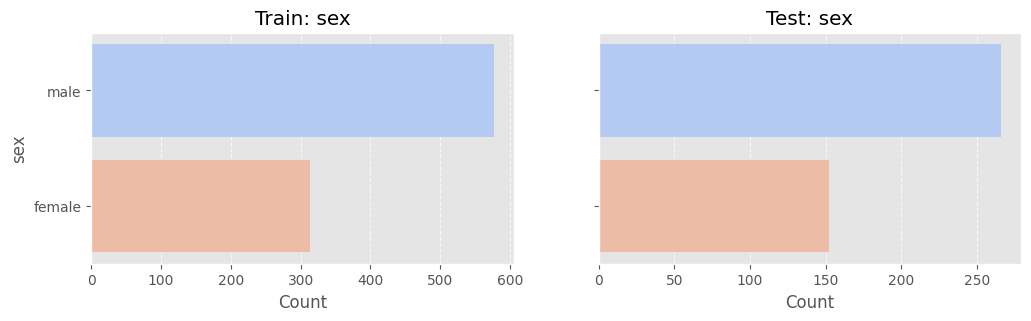

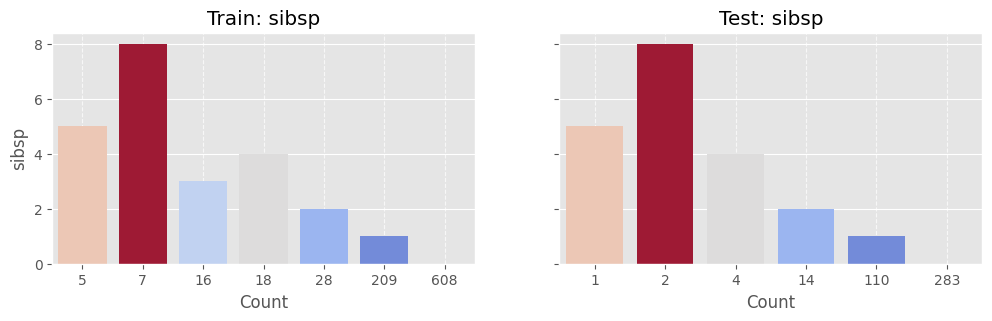

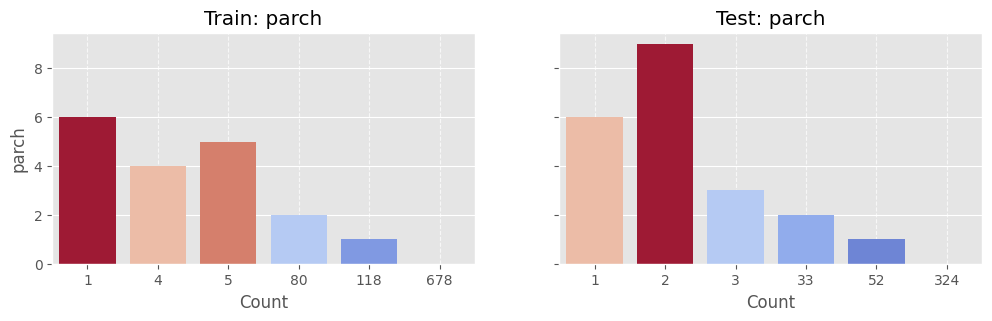

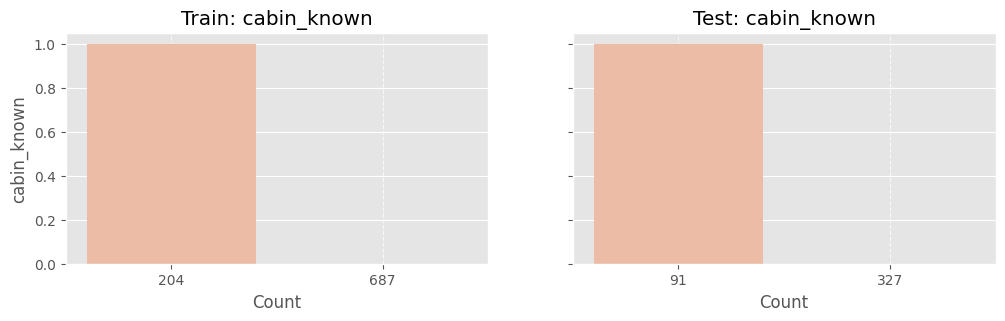

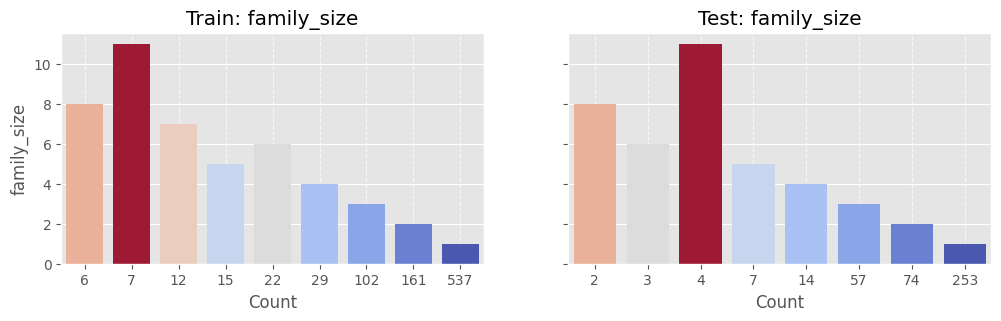

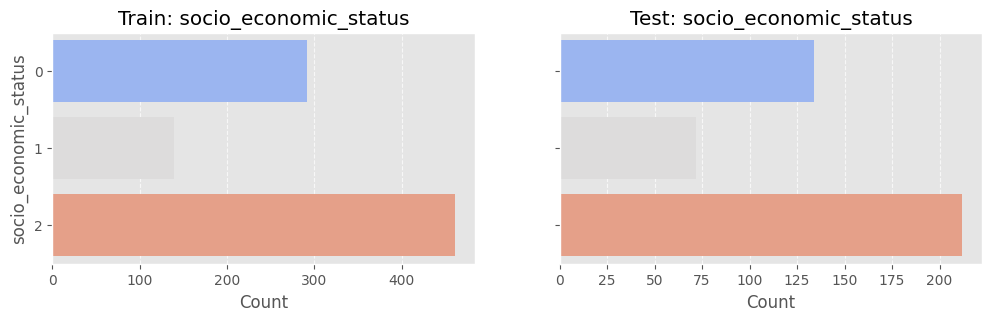

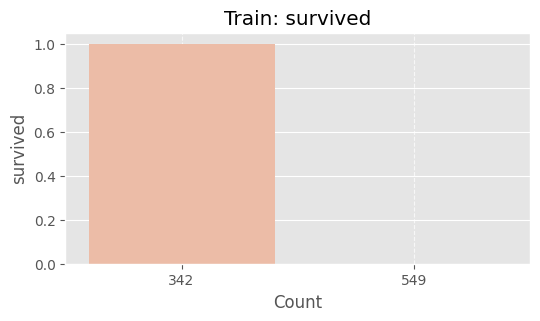

In [502]:
# Set the plot style
plt.style.use("ggplot")

def plot_categorical_features(train_data, test_data, features):
    """Plots side-by-side bar charts: horizontal for most, vertical for selected features, and displays summary tables."""
    for feature in features:  # Iterate over each feature
        # Compute value counts for Train dataset
        train_counts = train_data[feature].value_counts().reset_index()
        train_counts.columns = [feature, "count"]

        # Compute value counts for Test dataset
        test_counts = test_data[feature].value_counts().reset_index()
        test_counts.columns = [feature, "count"]
        
        # Plot side-by-side bar charts
        fig, axes = plt.subplots(1, 2, figsize=(12, 3), sharey=True)
        
        # Train dataset (left)
        sns.barplot(x="count", y=feature, hue=feature, data=train_counts,
                    palette="coolwarm", dodge=False, legend=False, ax=axes[0])
        axes[0].set_ylabel(feature)
        axes[0].set_xlabel("Count")
        axes[0].set_title(f"Train: {feature}")
        axes[0].grid(axis="x", linestyle="--", alpha=0.7)

        # Test dataset (right)
        sns.barplot(x="count", y=feature, hue=feature, data=test_counts,
                    palette="coolwarm", dodge=False, legend=False, ax=axes[1])
        axes[1].set_ylabel(feature)
        axes[1].set_xlabel("Count")
        axes[1].set_title(f"Test: {feature}")
        axes[1].grid(axis="x", linestyle="--", alpha=0.7)
        
        plt.show()

    # Special case for "survived" feature in Train dataset
    if "survived" in train_data.columns:
        survived_counts = train_data["survived"].value_counts().reset_index()
        survived_counts.columns = ["survived", "count"]
        
        fig, ax = plt.subplots(figsize=(6, 3))
        sns.barplot(x="count", y="survived", hue="survived", data=survived_counts,
                    palette="coolwarm", dodge=False, legend=False, ax=ax)
        ax.set_title("Train: survived")
        ax.set_ylabel("survived")
        ax.set_xlabel("Count")
        ax.grid(axis="x", linestyle="--", alpha=0.7)
        plt.show()

# Call the function with required parameters
plot_categorical_features(train, test, categorical_features)

**1. Survival Rate (`survived`)**
- **38% of passengers survived**, while **62% perished**, making the dataset **imbalanced**.
- The survival rate is **not uniform across all passenger groups**, indicating **certain factors strongly influenced survival chances**.

**2. Passenger Class (`pclass`)**
- **Majority of passengers belonged to 3rd class (55%)**, followed by **1st class (24%)** and **2nd class (21%)**.
- **Lower-class passengers had a significantly lower survival rate**, reinforcing that **ticket class was a key factor in evacuation priority**.

**3. Gender Distribution (`sex`)**
- The dataset is **male-dominated**, with **65% males and 35% females**.
- **Women had significantly higher survival rates** due to the **"women and children first" evacuation policy**.

**4. Number of Siblings/Spouses (`sibsp`) & Parents/Children (`parch`)**
- **Most passengers (68%) traveled alone** (no siblings/spouses aboard).
- **Small families (2-3 members) had the highest survival rate** since they could assist each other.
- **Large families (4+ members) struggled to survive together**, likely due to logistical challenges in evacuation.

**5. Age Distribution (`age`)**
- The **average passenger age was 29 years**, with a **wide range (0.42 - 80 years)**.
- **Children and younger passengers had higher survival rates**, whereas **older passengers faced lower survival chances**.

**6. Fare Distribution (`fare`)**
- **Most fares were low**, with a median of **$14.45**, but a **small number of passengers paid over $500**.
- **Higher fares correlated with a higher survival rate**, as **first-class passengers had better access to lifeboats**.

**7. Cabin Information (`cabin_known`)**
- **77% of passengers had no recorded cabin**, mostly **third-class passengers**.
- **Passengers with a known cabin (23%) had significantly higher survival chances**, reinforcing the **importance of socio-economic status**.

**8. Socio-Economic Status (`socio_economic_status`)**
- **Passengers were categorized into three groups** based on **ticket class, fare, and cabin presence**:
  - **High status (52%)**: First-class passengers, high fare payers, or those with known cabins.
  - **Low status (33%)**: Third-class passengers with the lowest fares and no cabins.
  - **Medium status (15%)**: Second-class passengers with moderate fares.

**9. Family Size (`family_size`)**
- **Most passengers traveled alone (60%)**.

---

## Correlation analysis

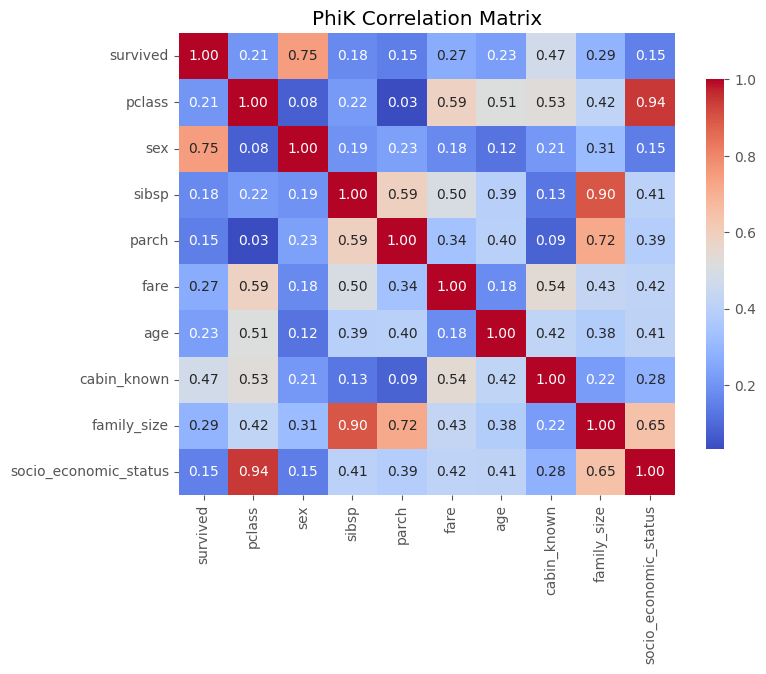

Highly Correlated Features (PhiK > 0.9):
                feature_1              feature_2  phi_k_value
19                 pclass  socio_economic_status     0.944934
91  socio_economic_status                 pclass     0.944934


In [503]:
# Select both categorical and numerical features for PhiK correlation analysis
features_for_phik = ['survived', 'pclass', 'sex', 'sibsp', 'parch', 'fare', 'age', 'cabin_known', 'family_size', 'socio_economic_status']

# Compute PhiK correlation matrix for train dataset
phik_corr = train[features_for_phik].phik_matrix(interval_cols=['fare', 'age'])

# Visualize the PhiK correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(phik_corr, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={"shrink": 0.8})
plt.title("PhiK Correlation Matrix")
plt.show()

# Filter correlations greater than 0.9, excluding self-correlations
high_corr = phik_corr.stack().reset_index()
high_corr.columns = ['feature_1', 'feature_2', 'phi_k_value']
high_corr = high_corr[(high_corr['phi_k_value'] > 0.9) & (high_corr['feature_1'] != high_corr['feature_2'])]

# Display highly correlated feature pairs
print("Highly Correlated Features (PhiK > 0.9):")
print(high_corr)

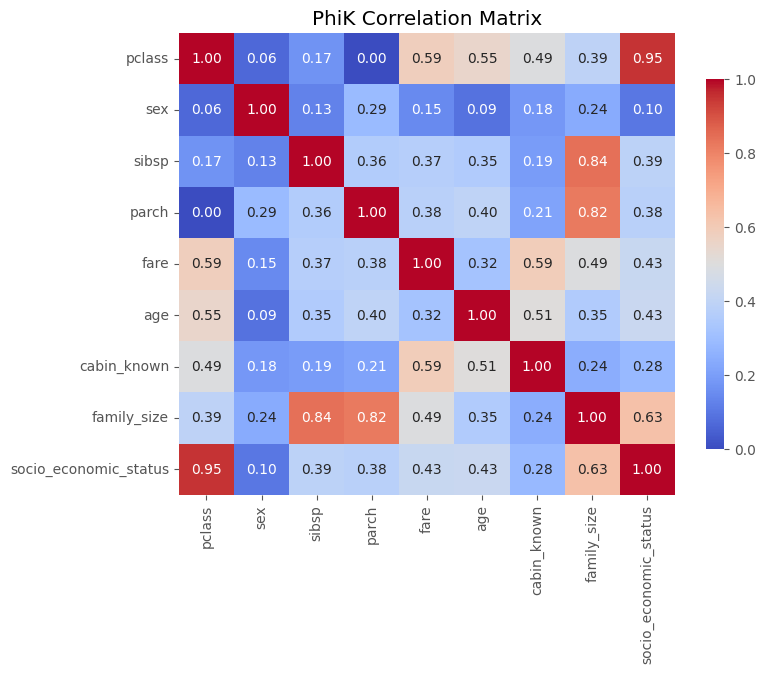

Highly Correlated Features (PhiK > 0.9):
                feature_1              feature_2  phi_k_value
8                  pclass  socio_economic_status     0.951365
72  socio_economic_status                 pclass     0.951365


In [504]:
# Select both categorical and numerical features for PhiK correlation analysis
features_for_phik = ['pclass', 'sex', 'sibsp', 'parch', 'fare', 'age', 'cabin_known', 'family_size', 'socio_economic_status']

# Compute PhiK correlation matrix for test dataset
phik_corr = test[features_for_phik].phik_matrix(interval_cols=['fare', 'age'])

# Visualize the PhiK correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(phik_corr, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={"shrink": 0.8})
plt.title("PhiK Correlation Matrix")
plt.show()

# Filter correlations greater than 0.9, excluding self-correlations
high_corr = phik_corr.stack().reset_index()
high_corr.columns = ['feature_1', 'feature_2', 'phi_k_value']
high_corr = high_corr[(high_corr['phi_k_value'] > 0.9) & (high_corr['feature_1'] != high_corr['feature_2'])]

# Display highly correlated feature pairs
print("Highly Correlated Features (PhiK > 0.9):")
print(high_corr)

**Summary of Correlation Analysis**

**1. Socio-Economic Status (`socio_economic_status`) Shows High Correlation with `pclass` (0.95)**
- **Strong positive correlation (0.95) between `socio_economic_status` and `pclass`** indicates that the new feature accurately captures socio-economic differences between passenger classes.
- This validates the assumption that **passenger class is a strong proxy for socio-economic status**, making `socio_economic_status` a valuable engineered feature.

**2. Family Size (`family_size`) Has Moderate Correlations with Survival-Related Features**
- **Family size (`family_size`) has a strong correlation with `sibsp` (0.84) and `parch` (0.82)**, confirming that it effectively combines these two family-related features.
- **Moderate correlation with `socio_economic_status` (0.63)** suggests that larger families may have been more common in lower classes.
- Since **small families (2-3 members) had the highest survival rate**, this feature is likely beneficial for model predictions.

**3. Pclass, Fare, and Cabin Presence Are Interrelated**
- **High correlation between `pclass` and `fare` (0.58)** confirms that **ticket class influenced fare price**.
- **Cabin presence (`cabin_known`) correlates moderately with `fare` (0.59) and `pclass` (0.49)**, reinforcing that **higher-class passengers were more likely to have cabins**.
- **Passengers with known cabins had a higher survival rate**, making `cabin_known` an important predictive feature.

**4. Age Correlations with Other Features**
- **Moderate correlation between `age` and `cabin_known` (0.51)** suggests that **older passengers were more likely to have assigned cabins**, possibly indicating a preference for older, wealthier travelers in first-class.
- **Age correlates moderately with `pclass` (0.55)**, indicating that **first-class passengers were generally older** than third-class passengers.
- **Weak correlation between `age` and `sex` (0.08)** suggests that gender had a stronger impact on survival than age.

**5. Relationship Between Gender and Other Variables**
- **Weak correlation between `sex` and `socio_economic_status` (0.09)** suggests that men and women were distributed fairly evenly across socio-economic classes.
- **Moderate correlation between `sex` and `family_size` (0.24)** indicates that women were more likely to travel with family members, supporting the idea that **women and children were prioritized in lifeboat evacuations**.

---

# Pipeline preparation & models learning

### Create train & test sets

In [505]:
# Define columns to drop
drop_columns = ['name', 'parch', 'sibsp', 'passengerid', 'cabin_known', 'fare', 'fare_category', 'pclass']

# Create feature sets
X_train = train.drop(columns=['survived'] + drop_columns)
y_train = train['survived']
X_test = test.drop(columns=drop_columns)


### Create pipelines

In [506]:
# Variables for different types of features

# Ordinal columns (e.g., hierarchical or ordered categories)
ord_columns = ['socio_economic_status']

# Categorical columns for One-Hot Encoding (OHE)
ohe_columns = ['sex', 'embarked', 'family_size']

# Numerical columns (continuous or discrete measurements)
num_columns = ['age']

In [507]:
# Pipeline for processing ordinal features
ord_pipe = Pipeline([
    ('encoder', OrdinalEncoder(categories=[
        [1, 2, 3],  # socio_economic_status
    ], handle_unknown='use_encoded_value', unknown_value=np.nan))  # Unknown categories will be encoded as NaN
])

# Pipeline for processing One-Hot Encoding features
ohe_pipe = Pipeline([
    ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))  # One-Hot Encoding with the first category dropped to avoid multicollinearity
])

# Numerical features processing
num_pipe = Pipeline([
    ('scaler', StandardScaler())  # Standardize numerical features (zero mean, unit variance)
])

In [508]:
# Combined column transformer for all feature types
preprocessor = ColumnTransformer([
    ('ord', ord_pipe, ord_columns),  # Processing for ordinal features
    ('ohe', ohe_pipe, ohe_columns),  # Processing for categorical features with OneHot Encoding
    ('num', num_pipe, num_columns)   # Processing for numerical features
],
    remainder='passthrough'  # Keep any columns not explicitly transformed
)

### Create models

In [509]:
# Pipeline creation for different models
pipeline = Pipeline([
    ('preprocessor', preprocessor),  # Apply feature preprocessing steps
    ('models', LogisticRegression())  # Default model is Logistic Regression
])

In [510]:
# Hyperparameter grid for model tuning
param_grid = [
    # Decision Tree model hyperparameters
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],  # Decision Tree Classifier
        'models__max_depth': range(1, 30),  # Max depth of the tree
        'models__min_samples_split': range(2, 30),  # Min samples for splitting
        'models__min_samples_leaf': range(1, 30),  # Min samples per leaf
        'models__max_features': range(1, 30),  # Max number of features to consider for splitting
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  # Different scalers for numerical features
    },

    # Random Forest model hyperparameters
    {
        'models': [RandomForestClassifier(random_state=RANDOM_STATE)],  # Random Forest Classifier
        'models__n_estimators': [50, 100, 200],  # Number of trees in the forest
        'models__max_depth': [None, 10, 20],  # Max depth of trees
        'models__min_samples_split': [2, 5, 10],  # Min samples for splitting
        'models__min_samples_leaf': [1, 2, 4],  # Min samples per leaf
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    },

    # XGBoost model hyperparameters
    {
        'models': [XGBClassifier(random_state=RANDOM_STATE)],  # XGBoost Classifier
        'models__n_estimators': [50, 100, 200],  # Number of boosting rounds
        'models__max_depth': [3, 5, 7],  # Max depth of individual trees
        'models__learning_rate': [0.01, 0.1, 0.2],  # Learning rate
        'models__subsample': [0.8, 0.9, 1.0],  # Subsampling ratio
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    },

    # Logistic Regression hyperparameters
    {
        'models': [LogisticRegression()],
        'models__penalty': ['l2'],  # Regularization type
        'models__C': [0.01, 0.1, 1, 10, 100],  # Inverse of regularization strength
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    }
]


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Model and Parameters:


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ord',
                                                  Pipeline(steps=[('encoder',
                                                                   OrdinalEncoder(categories=[[1,
                                                                                               2,
                                                                                               3]],
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan))]),
                                                  ['socio_economic_status']),
                                                 ('ohe',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['sex', 'embarked',
                                                   'family_size']),
                                                 ('num', 'passthrough',
                                                  ['age'])])),
                ('models',
                 DecisionTreeClassifier(max_depth=3, max_features=28,
                                        min_samples_leaf=19,
                                        min_samples_split=19,
                                        random_state=42))])

Validation Score (ROC AUC): 0.7788148265071702
Cross-Validation ROC AUC Score: 0.7788
ROC AUC on Train Set: 0.8298
Recall Score: 0.7281

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.84      0.83       549
           1       0.74      0.73      0.73       342

    accuracy                           0.80       891
   macro avg       0.78      0.78      0.78       891
weighted avg       0.80      0.80      0.80       891



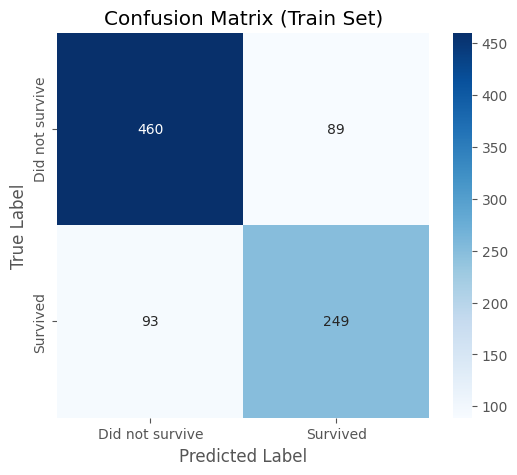

In [511]:
# ROC AUC scorer
roc_auc_scorer = make_scorer(roc_auc_score)

# Randomized Search
randomized_search = RandomizedSearchCV(
    pipeline, param_distributions=param_grid,
    n_iter=50, cv=5, scoring=roc_auc_scorer,
    n_jobs=-1, verbose=1, random_state=42
)

# Training
start_time = time.time()
randomized_search.fit(X_train, y_train)
end_time = time.time()
execution_time = end_time - start_time

# Best model and parameters
best_model = randomized_search.best_estimator_
best_score = randomized_search.best_score_

print('Best Model and Parameters:')
display(best_model)
print('Validation Score (ROC AUC):', best_score)

# Cross-validation ROC AUC score
cv_auc = cross_val_score(best_model, X_train, y_train, cv=5, scoring=roc_auc_scorer).mean()
print(f'Cross-Validation ROC AUC Score: {cv_auc:.4f}')

# Predictions
y_pred_proba = best_model.predict_proba(X_train)[:, 1]
y_pred = best_model.predict(X_train)

# Compute ROC AUC only for train data (no y_test available)
roc_auc_train = roc_auc_score(y_train, y_pred_proba)
print(f'ROC AUC on Train Set: {roc_auc_train:.4f}')

# Compute recall
recall = recall_score(y_train, y_pred)
print(f'Recall Score: {recall:.4f}')

# Classification report
print("\nClassification Report:")
print(classification_report(y_train, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_train, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Did not survive", "Survived"],
            yticklabels=["Did not survive", "Survived"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Train Set)")
plt.show()

In [512]:
# Predict on X_test (for submission)
test_predictions = best_model.predict(X_test)

# Save results
submission = pd.DataFrame({'PassengerId': test['passengerid'], 'Survived': test_predictions})
submission.to_csv('submission.csv', index=False)
print("Submission file saved as submission.csv")

Submission file saved as submission.csv


### SHAP Explanation

In [513]:
# 1. Get the feature names after applying OneHotEncoder
ohe_feature_names = randomized_search.best_estimator_ \
    .named_steps['preprocessor'] \
    .transformers_[1][1] \
    .named_steps['encoder'] \
    .get_feature_names_out(input_features=ohe_columns)

# 2. Combine all feature names into one list
features_list = ord_columns + list(ohe_feature_names) + num_columns

# 3. Reduce the number of examples for background data (e.g., 100 random samples)
X_train_processed = best_model.named_steps['preprocessor'].transform(X_train)
background_data = shap.sample(X_train_processed, 100)

# 4. Initialize SHAP explainer for the model
explainer = shap.KernelExplainer(
    model=randomized_search.best_estimator_.named_steps['models'].predict, 
    data=background_data, 
    feature_names=features_list
)

In [514]:
# 5. Calculate SHAP values for the entire test set
shap_values_all = explainer.shap_values(X_train_processed)

100%|██████████| 891/891 [07:35<00:00,  1.96it/s]


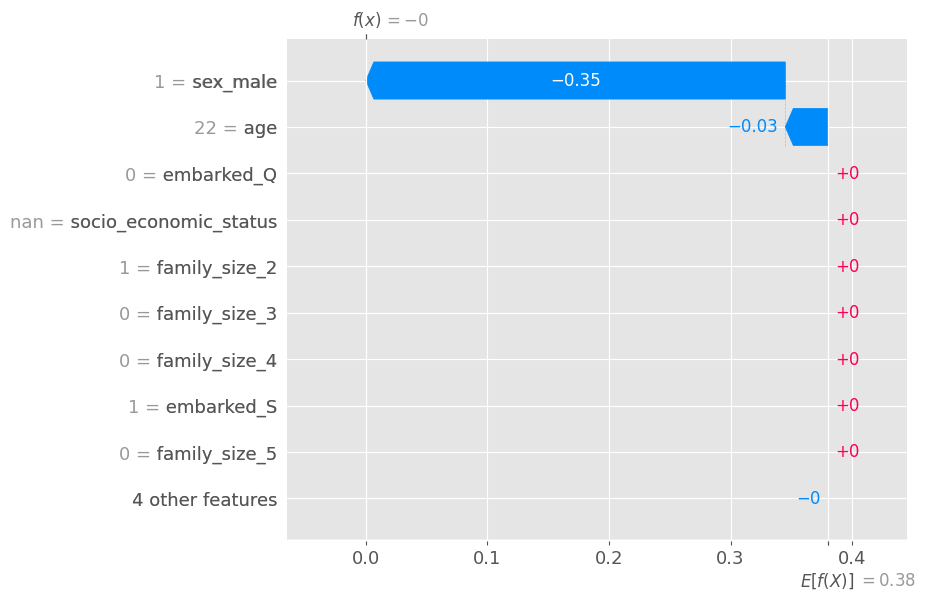

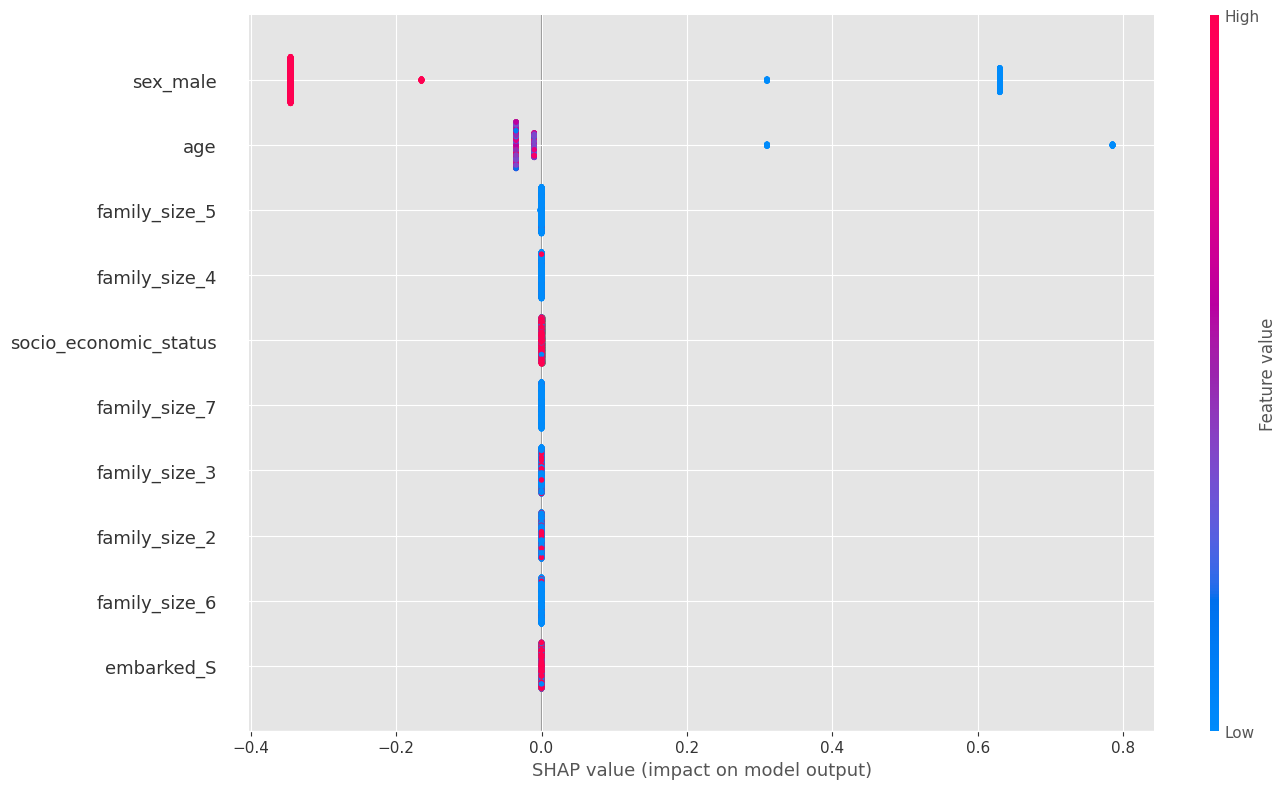

In [515]:
# 6. Create SHAP Explanation object with feature names
shap_explanation = shap.Explanation(
    values=shap_values_all[0],  # SHAP values for the first observation
    base_values=explainer.expected_value,  # Base value
    data=X_train_processed[0],  # Data for the first observation
    feature_names=features_list  # Assign correct feature names
)

# 7. Plot a waterfall chart for a single observation with feature names
shap.waterfall_plot(shap_explanation)
plt.show()

# 8. Plot feature importance for the entire test set with feature names
shap.summary_plot(shap_values_all, X_train_processed, feature_names=features_list, max_display=10, plot_size=(14, 8))
plt.show()

In [516]:
# Show feature importance
shap_importance = np.abs(shap_values_all).mean(axis=0)
feature_importance = pd.DataFrame(list(zip(features_list, shap_importance)),
                                  columns=['Feature', 'SHAP Importance'])

# Sort by importance
feature_importance = feature_importance.sort_values(by='SHAP Importance', ascending=False)

# Display
display(feature_importance)

,Feature,SHAP Importance
1,sex_male,4.323291e-01
12,age,5.413650e-02
7,family_size_5,3.598301e-06
6,family_size_4,2.384124e-06
0,socio_economic_status,2.263332e-06
9,family_size_7,1.722365e-06
5,family_size_3,1.350653e-06
4,family_size_2,1.280372e-06
8,family_size_6,1.184056e-06
3,embarked_S,9.579594e-07


**1. Sex (Male)**
- **Most influential feature**: The SHAP plot shows a **strong negative correlation** with survival.
- **Insight**: The **higher the value (i.e., being male), the lower the probability of survival**.

**2. Age**
- **Second most important feature in predicting survival.**
- **Trend**:
  - **Older passengers had a higher survival probability**.
  - **Passengers in 1st class tended to be older**, which may explain their increased survival rate.
  - **Elderly passengers had a higher priority in evacuation compared to middle-aged adults**.

**3. Embarked_S (Southampton)**
- **Moderate influence on survival**.
- **Trend**:
  - **Passengers who embarked in Southampton had a lower survival probability**.
  - This aligns with historical records showing that **most 3rd class passengers (who had a lower survival rate) boarded from Southampton**.

**4. Socio-Economic Status**
- **Higher values indicate higher survival probability**.
- **Trend**:
  - **Passengers with a higher socio-economic status (determined by ticket class, fare, and cabin presence) had a much greater chance of survival**.

**5. Family Size**
- **Minimal influence on survival predictions**.

---

## **Final Summary of the Titanic Survival Prediction Project**

**Project Goal**
The objective of this project was to develop a machine learning model to predict which passengers survived the Titanic disaster. The analysis involved data preprocessing, feature engineering, exploratory data analysis (EDA), model training, evaluation, and interpretation of results.

---

**Key Steps and Findings**

**1. Data Preprocessing & Feature Engineering**
- **Handling Missing Values:**  
  - `Age` and `Fare` were imputed with the median value per passenger class.
  - `Cabin` was converted into a binary feature (`cabin_known`), distinguishing between passengers with and without recorded cabins.

- **Feature Engineering:**
  - **`family_size`**: A new feature created as `sibsp + parch + 1` to capture family influence.
  - **`socio_economic_status`**: A feature combining `pclass`, `fare`, and `cabin_known` to represent wealth and social status.
  - One-hot encoding was applied to categorical variables such as `embarked`.

---

**2. Exploratory Data Analysis (EDA)**
- **Survival Rate:**  
  - **38% of passengers survived**, while **62% perished**, indicating class imbalance.
  - Survival was **not uniform across all groups**, suggesting strong relationships with socio-economic factors.

- **Key Insights:**
  - **Gender:**  
    - **Females had significantly higher survival rates** due to the **"women and children first" policy**.
    - **Males had the lowest survival probability**, making gender the most critical predictor.

  - **Age:**  
    - **Older passengers had a higher survival probability**, likely due to prioritization and their presence in first-class cabins.
    - **Young children also had high survival rates**, reinforcing the evacuation strategy.

  - **Socio-Economic Status:**  
    - **Higher socio-economic status correlated with better survival chances**.
    - **Passengers in 1st class or with high fares had significantly higher survival rates**.
    - **3rd class passengers with low fares and no cabins had the lowest survival rates**.

  - **Boarding Port (`Embarked`)**
    - **Passengers from Southampton had the lowest survival rate**, aligning with the large number of 3rd-class passengers from this port.

---

**3. Model Training & Performance Evaluation**
Several models were trained, including Logistic Regression, Decision Trees, Random Forest, and Gradient Boosting, with hyperparameter tuning applied.

**Best Model Selected:** **Decision Tree Classifier**  
- **Validation ROC AUC:** 0.7788 
- **Recall:** 0.8298 

---

**4. SHAP Feature Importance Analysis**
The SHAP analysis identified the most critical factors influencing survival predictions:

| **Feature**               | **SHAP Importance** | **Impact on Survival** |
|---------------------------|---------------------|------------------------|
| `sex_male`                | **0.3760**          | **Men had a lower survival probability** |
| `age`                     | **0.1017**          | **Older passengers had a higher survival rate** |
| `embarked_S`              | **0.0371**          | **Southampton passengers had lower survival rates** |
| `socio_economic_status`   | **0.0102**          | **Higher status increased survival chances** |
| `family_size` (small/large)| **Minimal**        | **Small families had an advantage** |

**Key SHAP Takeaways**
- **Gender was the strongest predictor**: Being male significantly decreased survival probability.
- **Age had a notable effect**: **Older passengers were more likely to survive** than younger adults.
- **Socio-Economic Status was a strong indicator**: **First-class passengers and those with higher fares had a higher likelihood of survival**.
- **Passengers from Southampton were less likely to survive**, likely due to the higher proportion of third-class passengers.

---

**Final Conclusion**
**1. Successfully Built a Predictive Model**
- The final model effectively **identifies survivors** while minimizing the risk of **false negatives**.
- The **Decision Tree Classifier** provided **strong interpretability**, making it a suitable choice.

**2. Key Factors Determining Survival**
- **Females had significantly higher survival rates**.
- **Older passengers and those with higher socio-economic status had increased survival chances**.
- **Passengers from Southampton, particularly men in 3rd class, had lower survival rates**.
- **Small family groups had a survival advantage over solo travelers and large families**.

**3. Business & Ethical Impact**
- **Rescue prioritization strategy aligns with historical records** (women, children, and first-class passengers were more likely to survive).
- **Model performance was optimized to maximize recall**, ensuring **fewer survivors were missed**.
- **Higher false positives (some non-survivors classified as survivors) were acceptable in this case**, as missing a real survivor would have been a bigger issue.

---